# Emcee GP Study

An emcee sampler notebook, testing various things about the emcee package.

In [1]:
%matplotlib notebook 
#restart the kernel if switching from inline to notebook
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import corner

import numpy as np
import scipy.stats
import pandas as pd

import emcee
import george

import gp_sandbox as cgp

In [2]:
def subsample(time, flux, flux_err=None, npoints=100, kind="random",
              time_unit="days", night_length=8.0, seed=42,
              sigma=0.0, mean_flux=0.0, dnights=[3,6]):
    """
    Subsample an existing high-resolution time series (e.g. simulated) 
    using different sampling patterns.
    
    Parameters
    ----------
    time : numpy.ndarray
        The array of time stamps 
    
    flux : numpy.ndarray
        The array of flux values corresponding to the time 
        stamps in `time`
        
    npoints : int
        The number of data points to sub-sample
        
    kind : str, one of {random | telescope}
        The type of subsampling to perform. 
        There are different sampling patterns currently implemented:
            "random" : randomly sample `npoints` data points from 
                       `time` and `flux1`          
            "telescope": take day/night cycle into account, but randomly 
                         subsample within a "night"
            "sparse" : sparse asteroid sampling: 3 x 1-minute images, separated by 21-minute intervals,
                                                 whole night, for K nights in a row and N nights per semester
            "ztf" : 
            
    time_unit : str
        The unit of time that the `time` array is in.
    
    night_length : float
        The length of a night in hours for including day/night cycles
                
    seed : int
        Seed for the random number generator. Useful for reproducibility.
    
    dnights : [min_nights, max_nights]
        The minimum and maximum number of nights between consecutive observations. Used for 
        the ZTF-like sampling
        
    Returns
    -------
    tsmall, fsmall, (ferrsmall) : the subsampled time series
    """

    if seed is not None:
        np.random.seed(seed)

    if kind == "random":
        # generate a random list of indices for sub-sampling
        idx = np.random.choice(np.arange(0, time.shape[0], 1, dtype=int),
                               size=npoints, replace=False)

        tsmall = time[np.sort(idx)]
        fsmall = flux[np.sort(idx)]
        if flux_err is not None:
            ferrsmall = flux_err[np.sort(idx)]
        else:
            ferrsmall = np.zeros_like(fsmall) + sigma

    elif kind == "telescope":
        # if time unit is in days, convert length of night and day 
        # from hours into days
        if time_unit == "days":
            night_length /= 24.0
            tseg = time[-1] - time[0] # total length of the time series
        else:
            tseg = (time[-1] - time[0]) / 24.0

        nightly_points = int(npoints/tseg)

        tstart = time[0]
        tend = tstart + night_length

        tsmall = []
        fsmall = []

        ferrsmall = []
        while tend <= time[-1]:
            min_ind = time.searchsorted(tstart)
            max_ind = time.searchsorted(tend)

            tshort = time[min_ind:max_ind]
            fshort = flux[min_ind:max_ind]


            idx = np.random.choice(np.arange(0, tshort.shape[0], 1, dtype=int),
                           size=nightly_points, replace=False)

            tsample = tshort[np.sort(idx)]
            fsample = fshort[np.sort(idx)]

            tsmall.append(tsample)
            fsmall.append(fsample)

            if flux_err is not None:
                ferrshort = flux_err[min_ind:max_ind]
                ferrsample = ferrshort[np.sort(idx)]
                ferrsmall.append(ferrsample)
            else:
                ferrsmall.append(np.zeros_like(fsample) + sigma)

            if time_unit == "days":
                tstart += 1.0
                tend += 1.0
            elif time_unit == "hours":
                tstart += 24.0
                tend += 24.0

    elif kind == "sparse":
        if time_unit == "days":
            night_length /= 24.0
            tseg = time[-1] - time[0] # total length of the time series
        else:
            tseg = (time[-1] - time[0]) / 24.0

        tstart = time[0]
        tend = tstart + night_length

        tsmall = []
        fsmall = []

        ferrsmall = []

        start_id = np.random.randint(0, 8, size=1)

        # one minute in fractions of days
        dt = 1./(60*24.)

        # start within the 24-minute interval of observing different asteroids
        tstart += start_id*(3*dt)

        while tend <= time[-1]:

            while tstart <= tend:
                for j in range(3):
                    tind = time.searchsorted(tstart)
                    tsmall.append(time[tind])
                    fsmall.append(flux[tind])

                    if flux_err is not None:
                        ferrsmall.append(flux_err[tind])
                    else:
                        ferrsmall.append(sigma)

                    tstart += dt

                tstart += 21.*dt

            if time_unit == "days":
                tstart += (1.0-night_length)
                tend += 1.0
            elif time_unit == "hours":
                tstart += (24.0 - night_length)
                tend += 24.0
    elif kind == "ztf":

        tstart = time[0]
        total_nights = time[-1] - time[0]

        tsmall = []
        fsmall = []

        nnights = int(npoints/2.)
        if nnights > total_nights:
            raise ValueError("Number of selected nights is longer than total light curve.")

        dnights = np.random.randint(dnights[0], dnights[1], size=npoints)
        dnights[1::2] = 0
        nights = np.zeros(npoints, float) + dnights
        nights = nights.cumsum()

        if np.max(nights) > time[-1]:
            print("Warning! The requested observations are spread over more nights" +
                  " than we currently have data for! Actual number of nights will be smaller!")

        # After 1 month, given field rises 2 hours earlier
        # Let's say we start @ +/- 1 hour of midnight
        start_times = (np.random.random(npoints) * 2.0 - 1.0) * 60.0
        start_times[::2] = start_times[1::2]
        dtimes = np.random.randint(30, 51, size=npoints)
        dtimes[::2] = 0
        times = nights + (start_times  + dtimes) / 60.0 /  24.0 + (nights * -2./24./30.)

        ferrsmall = []
        times += tstart

        for t in times:
            t_ind = time.searchsorted(t)
            tsmall.append(time[t_ind])
            fsmall.append(flux[t_ind])

            if flux_err is not None:
                ferrsmall.append(flux_err[t_ind])
            else:
                ferrsmall.append(sigma)

    fsmall = np.random.normal(np.hstack(fsmall), scale=np.hstack(ferrsmall)) + mean_flux

    return np.hstack(tsmall), np.hstack(fsmall), np.hstack(ferrsmall)


In [78]:
def sample(all_time, all_flux, asteroid=None, days=1, delay=0, plot=True):
    
    """
    Samples the number of points from the provided lightcurve at a 
    specified cadence.
    The total simulated light curve has around 400,000 points/~160 days.
    
    Parameters
    ----------
    days : int
        The number of nights you wish to sample. There are 2880 data 
        points in each day.
        
    delay : int
        The number of days you wish to delay by. This allows the user to
        sample the lightcurve somewhere other than just the start.
        Note : you cannot delay by more than 158 days or the data runs 
        out.
        
    plot : boolean
        Decides whether you want to plot the original light curve and 
        the sampled data points.
    
    Returns
    -------
    time : pandas.core.series.Series
        The time stamp information of the sampled lightcurve in days.
        
    flux : pandas.core.series.Series
        Flux measurements of sampled lightcurve corresponding to the
        time stamps.
        
    flux_err : numpy.ndarray
        Estimated flux error corresponding to the flux measurements.
        
    ax : matplotlib.axes._subplots.AxesSubplot

    """
    # halt if you delay past he limit of the data
    assert delay < 159 , "You cannot delay more than 158 days."
    
    # convert days to points
    span = 2880 * days
    start_pt = 2880 * delay
    
    # read in lightcurve data

    # halt if you sample past the limit of the data
    assert 2880*(delay+days) < len(all_time) , "End of data reached. You cannot delay that many days."
    
    time = all_time[start_pt:span+start_pt]
    flux = all_flux[start_pt:span+start_pt]

    # yerr is set to 0.2 magnitude but can easily be changed
    # cadance sampling is turned on
    # can be switched to random or clustered
    tsample, fsample, flux_err = cgp.sample_data(time, flux, yerr_amp=0.2, cadence_n=1) 

    if plot == True:
        ax = plot_sample(time, flux, tsample, fsample, asteroid)
        return tsample, fsample, time, flux, flux_err, ax

    else: return tsample, fsample, time, flux, flux_err


def plot_sample(time, flux, tsample, fsample, asteroid):
    
    """
    Plot the sampled data points.
    """
    
    if asteroid == 3200:
        true_period = 3.603957 # 3200 Phaeton
        true_log_p = -1.896021
        
        
    elif asteroid == 1291:
        true_period = 5.58410 # 1291 Phryge
        true_log_p = -1.45813055
    
        
    elif asteroid == 221:
        true_period = 10.443 # 221 Eos
        true_log_p = -0.8321219
      
    elif asteroid == 1388:
        true_period = 11.9432 # 1388 Aphrodite
        true_log_p = -0.69789175
        
    else:
        true_period = 0
        true_log_p = 0  
        
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    ax.plot(time, flux, '-', alpha=0.5, label="Original : " + str(round(true_log_p, 5)))
    #ax.plot(tsample, fsample, 'ko', ms = 3, alpha=0.5, 
                 
    ax.set_title("%i nights, %i data points"%(days, len(fsample)))
    ax.errorbar(tsample, fsample, yerr=flux_err, fmt="o", markersize=5, 
                color="black", zorder=10, label="Sample : " + str(len(tsample)))
    ax.legend()
    return ax
    

    
def prior(params):
    
    """
    Calculated the log of the prior values, given parameter values.
    
    Parameters
    ----------
    params : list
        List of all kernel parameters
    
    param[0] : float
        mean (between 0 and 2)
    
    param[1] : float
        log amplitude (between -10 and 10)
        
    param[2] : float
        gamma (log gamma between 0.1 and 100)
        
    param[3] : float
        log period (period between 1h and 24hrs)
    
    Returns
    -------
    sum_log_prior : int
        sum of all log priors (-inf if a parameter is out of range)
    
    """

    #p_mean = scipy.stats.uniform(0,20).logpdf(params[0])
    p_log_amp = scipy.stats.uniform(-10,30).logpdf(params[0])  
    p_log_gamma = scipy.stats.uniform(np.log(0.1), np.log(10)*3).logpdf(np.log(params[1]))
    p_period = scipy.stats.uniform(np.log(1./24), -np.log(1./24)).logpdf((params[2]))
    #p_period = scipy.stats.uniform(np.log(1./24), -np.log(1./(24*30))).logpdf((params[3])) #1-72 hrs
        
    #sum_log_prior =  p_mean + p_log_amp + p_log_gamma + p_period
    sum_log_prior = p_log_amp + p_log_gamma + p_period
    
    if np.isnan(sum_log_prior) == True:
        return -np.inf
    
    return sum_log_prior


def post_lnlikelihood(params):
    
    """
    Calculates the posterior likelihood from the log prior and 
    log likelihood. 
    
    Parameters
    ----------
    params : list
        List of all kernel parameters
        

    Returns
    -------
    ln_likelihood : float
        The posterior, unless the posterior is infinite, in which case,
        -1e25 will be returned instead.
        
    """    
    # calculate the log_prior
    log_prior = prior(params)
    
    # return -inf if parameters are outside the priors
    if np.isneginf(log_prior) == True:
        return -np.inf
    
    # compute lnlikelihood based on given parameters
    gp.set_parameter_vector(params)
    gp.compute(tsample, flux_err)
    
    ln_likelihood = gp.lnlikelihood(fsample)+log_prior
    
    return ln_likelihood if np.isfinite(ln_likelihood) else -1e25


def optimize(x, y, yerr, gp, print_result = True):
   
    """
    Optimizes kernel parameters with scipy.optimize.
    
    Parameters
    ----------
    x : pandas.core.series.Series
        The time stamp information of the sampled lightcurve in days.
        
    y : pandas.core.series.Series
        Flux measurements of sampled lightcurve corresponding to the
        time stamps.
    
    yerr : numpy.ndarray
        Estimated flux error corresponding to the flux measurements.
        This value can be changed in the sample function.
        
    print_results : boolean
        Toggles whethere you want extra information about the optimization
        results. 
        
    Returns
    -------
    result : scipy.optimize.optimize.OptimizeResult
        The result for optimizing. Will be using result.x for the 
        initial locations and result.hess_inv for the covariance matrix
        for a multivariate (4D) normal distribution that will provide
        starting locations for our emcee walkers.
          
    """
    
    # import needed function
    from scipy.optimize import minimize
    
    # compute kernel with given x and yerr 
    gp.compute(x, yerr)

    def neg_ln_like(p):
        gp.set_parameter_vector(p)
        try:
            negloglike =  -gp.log_likelihood(y)
            return negloglike
        # throw exception if you run into an error
        except scipy.linalg.LinAlgError:
            return np.inf

    def grad_neg_ln_like(p):
        gp.set_parameter_vector(p)
        try:
            grad_loglike =  -gp.grad_log_likelihood(y)
            return grad_loglike
        # throw exception if you run into an error
        except scipy.linalg.LinAlgError:
            return np.inf

    result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)#, method='L-BFGS-B')
    gp.set_parameter_vector(result.x)
    
    if (print_result == True):
        print(result)
    
    return result



def walker_params(params, cov_scale=1, plot=True):
    
    """
    Sets up the initial parameters for all the walkers using optimized 
    parameter values as starting values. The function generates a 
    scattered multivatiate gaussian distribution of starting parameter 
    values.
    
    Parameters
    ----------
    params : list
        List of all kernel parameters.
    
    cov_scale : float
        Determines the scatter of the multivariate distribution.
      
    Returns
    -------
    p0 : numpy.ndarray
        The initial walker parameters [nwalker, ndim]
    
    gp : george.gp.GP
        GP kernel set with the optimized parameter values.
        
    """
    
    
    mean, log_amp, gamma, log_period = params
    amp = np.exp(log_amp)

    print('amp : ' + str(amp))
    kernel = amp * george.kernels.ExpSine2Kernel(gamma = gamma, log_period = log_period)
    gp = george.GP(kernel)#, fit_mean=True, mean=mean)
    gp.compute(fsample, flux_err)
    result = optimize(tsample, fsample, flux_err, gp)
    print(result.x)
    p0 = np.random.multivariate_normal(mean=result.x, cov=cov_scale*result.hess_inv, size=nwalkers)
    if plot==True:
        plot_gpfit(time, tsample, fsample, flux_err, gp)
    
    return p0, gp

def plot_gpfit(time, tsample, fsample, flux_err, gp):
    
    """
    Plot a gp fit given a gp class and x, y, and yerr data to fit onto.
    
    """
      
    t_possible = np.linspace(time[0], time[-1], len(time))
    pred, pred_var = gp.predict(fsample, t_possible, return_var=True)
    
    temp_color = np.random.rand(3)
    
    ax.fill_between(t_possible, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="red", alpha=0.4)
    ax.plot(t_possible, pred, "red", lw=1.5, alpha=0.7, label = "GP Fit : " + str(round(gp.parameter_vector[-1], 5)))
    ax.legend()


## Skip the following cell if you are working with real data.

First we have to extract the time stamps and flux from any data files we might have. For simulated data, we have to sample it at a candence that would be similar to real observations, meaning we have 3 tyoes of flux and time data.
1. __data.time & data.flux__ : all the time and flux data from the simulated data. This might span multiple days-months and has a data point for every 30 seconds using DAMIT generated data

2. __time & flux__ : the time and flux data for a smaller range of dates than all_time and all_flux. This is essentially the observing window in which we are working with and time is what we will be projecting our gp fits onto

3. __tsample & fsample__ : the time and flux data sampled from the time and flux data. The sampling of this is more realistic (every 10 minutes instead of every 0.5 minutes)

In [79]:
asteroid = 1388
txt = '../data/'+str(asteroid)+'_lc_49627_to_49787.txt'

data = pd.read_csv(txt, delimiter=' ',
                 header=None, names=['time','flux'], dtype={'time':float, 'flux':float})

days, delay = 5, 2

# convert days to points
span = 2880 * days
start_pt = 2880 * delay

time = np.array(data.time[start_pt:span+start_pt])
flux = np.array(data.flux[start_pt:span+start_pt])

flux_err = np.ones_like(flux) * np.std(flux)/10.0

In [80]:
tsample, fsample, flux_err = subsample(time, flux, flux_err=flux_err, npoints=100, kind="random")

<IPython.core.display.Javascript object>


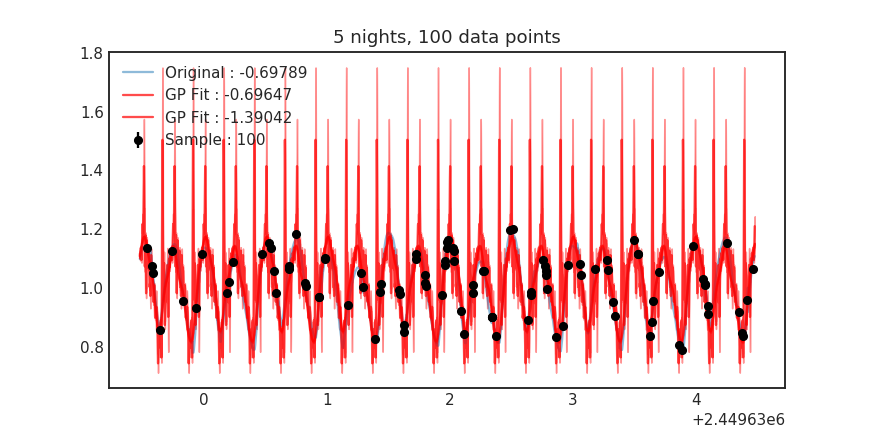

In [81]:
ax = plot_sample(time, flux, tsample, fsample, asteroid)

## Skip the following cell if you are working with simulated data.

Here's an alternative way of doing things if you're working with real data measurements. Since we're working with real data, we are essentially given __tsample__ and __fsample__. So we don't need to sample any points but this also means we don't know what the real light curve looks like. We can still generate a __time__ since it just needs to span from the first observation of __tsample__ to the last.

<IPython.core.display.Javascript object>


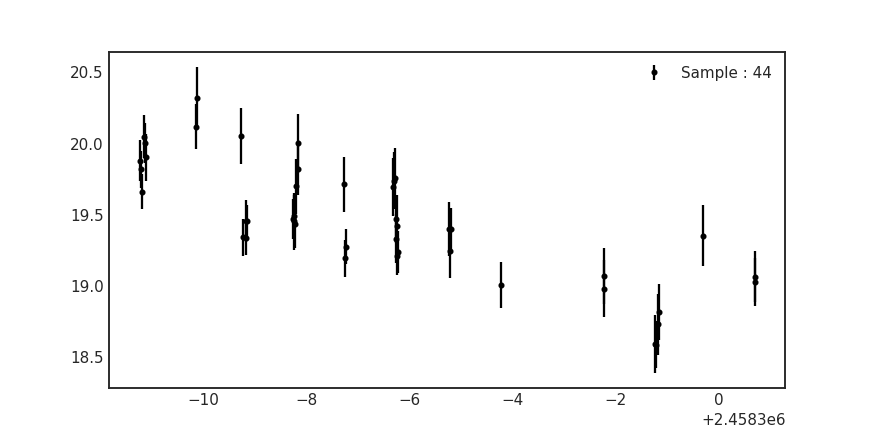

In [8]:
txt = '../data/asteroid_csv/2018LF05.csv'
data = pd.read_csv(txt)

tsample = data.jd
fsample = data.magpsf
flux_err = data.sigmapsf
data_pts = len(tsample)

tsample.iloc[-1]

time = pd.Series(np.linspace(tsample.iloc[0], tsample.iloc[-1], 1000))

fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.errorbar(tsample, fsample, yerr=flux_err, fmt = 'k.', label="Sample : " + str(len(tsample)))
ax.legend()

Let's see what a Lomb-Scargle periodogram predicts the period should be based on our data so far.

# Doesn't currently work. Need gatspy.


In [11]:
from lombscargle.py import make_lsp
from astropy.stats import LombScargle

freq, power = make_lsp(tsample, fsample, flux_err, p_max=5.0)

fig, bx = plt.subplots(1,1, figsize=(4,2))
bx.plot(freq, power)
bx.set_xlabel('Frequency')
bx.set_ylabel('Power')
best_freq = freq[np.argmax(power)]
best_log_period = np.log(1./best_freq)
bx.vlines(best_freq, 0, 1, colors='orange', linestyles='--', 
          label = 'Best fit : ' + str(round(best_freq, 5))+ '\nLog period : ' + str(round(best_log_period, 5)))
bx.legend()



y_fit = LombScargle(tsample, fsample, flux_err).model(time, best_freq)
ax.plot(time, y_fit, label = "Lomb-Scargle fit : " + str(round(best_log_period, 5)))
ax.legend()

ModuleNotFoundError: No module named 'gatspy'

In [49]:
new_freq = best_freq*(1./2)
new_log_period = np.log(1./new_freq)
y_fit = LombScargle(tsample, fsample, flux_err).model(time, new_freq)
ax.plot(time, y_fit, label = "Lomb-Scargle fit : " + str(round(new_log_period, 5)))
ax.legend()

How many walkers do we want? So far there are 4 parameters/dimensions we want to study: mean, log_amp, gamma, and log_period.

In [82]:
ndim, nwalkers = 3, 100

In [85]:
###initialize walker parameters
best_log_amp = np.log(flux.max()-flux.min())
params = [np.mean(fsample), best_log_amp, 1, -1.5]
p0, gp = walker_params(params=params, cov_scale=10, plot=True)

amp : 0.4081810000000001
      fun: 33.17677618696956
 hess_inv: array([[ 5.28394005e-02, -6.78042628e-01, -9.76732546e-08],
       [-6.78042628e-01,  5.07805569e+01, -9.01867885e-05],
       [-9.76732546e-08, -9.01867885e-05,  1.48567078e-08]])
      jac: array([-1.17819354e-09, -3.93773902e-12,  4.17232513e-06])
  message: 'Optimization terminated successfully.'
     nfev: 50
      nit: 30
     njev: 50
   status: 0
  success: True
        x: array([-0.58304395, 95.34970577, -1.39042448])
[-0.58304395 95.34970577 -1.39042448]


In [86]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, post_lnlikelihood, threads=10)

### Note

If your sampler fails within the first couple of seconds, try making the cov_scale smaller.

In [87]:
%%time
mcmc_sampling = sampler.run_mcmc(p0, 2000)

/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


CPU times: user 20.2 s, sys: 2.6 s, total: 22.8 s
Wall time: 1min 45s


In [ ]:
def save_chain(data, file_name):
    with file(file_name + '.txt', 'w') as outfile:
        # I'm writing a header here just for the sake of readability
        # Any line starting with "#" will be ignored by numpy.loadtxt
        outfile.write("# " + str(data.shape) + '\n')

        # Iterating through a ndimensional array produces slices along
        # the last axis. This is equivalent to data[i,:,:] in this case
        for data_slice in data:  
            np.savetxt(outfile, data_slice)

            # Writing out a break to indicate different slices...
            outfile.write('# New chain\n')

def read_chain(file_name, shape):
    new_data = np.genfromtxt(file_name + '.txt', delimiter=' ')
    # data shape can be found as the first commented line in the txt file
    new_data = new_data.reshape(shape)
    return new_data


Now we can save our data for later.

In [ ]:
save_chain(sampler.chain, '2001SC170')

Or read it out if we want to compare. If you want to plot the saved data, make sure to indicate it when plotting by setting __from_saved__ to True.

In [ ]:
test = read_chain('hello', (100,100,4))

In [88]:
def plot_steps(sampler, dims = None, p0=None, data_pts=None, from_saved=False):
    fig, ax = plt.subplots(2,2)
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    
    axs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]
    
    if from_saved==True:
        x = np.arange(sampler.shape[1])
        
        for i in range(sampler.dim):
            axs[i].set_xlabel('Step Number')
            axs[i].set_ylabel('{}'.format(dims[i]))
            
            for j in range(sampler.shape[0]):
                param = sampler[j,:,i]
                if i == 2: 
                    param = np.exp(param)*24
                axs[i].plot(x, param, 'k-', alpha=0.3)
                
            flatchain = sampler[:,:,i]
            if i == 2: 
                pre_mean = flatchain.mean()
                flatchain = np.exp(flatchain)*24
                axs[i].axhline(flatchain.mean(), linestyle='--', 
                               label=(str((round(flatchain.mean(),5)))+' \n'+str((round(pre_mean,5)))))
            
            else: axs[i].axhline(flatchain.mean(), linestyle='--', 
                                 label=round(flatchain.mean(),5))
            axs[i].legend(loc=1)

    else:        
        x = np.arange(sampler.iterations)

        print(str(p0[0]) + '\nData points: ' + str(data_pts))
        print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

        for i in range(sampler.dim):
            axs[i].set_xlabel('Step Number')
            axs[i].set_ylabel('{}'.format(dims[i]))
            
            for j in range(len(sampler.chain)):
                param = sampler.chain[j,:,i]
                if i == len(dims)-1: 
                    param =  np.exp(param)*24
                axs[i].plot(x, param, 'k-', alpha=0.3)
                # fit might guess period is time range of sampling
                
            flatchain = sampler.flatchain[:,i]
            if i == len(dims)-1: 
                pre_mean = flatchain.mean()
                flatchain = np.exp(flatchain)*24
                axs[i].axhline(flatchain.mean(), linestyle='--' , label=(str((round(flatchain.mean(),5)))+'\n'+str((round(pre_mean,5)))))
            
            else: axs[i].axhline(flatchain.mean(), linestyle='--' , label=round(flatchain.mean(),5))
            axs[i].legend(loc=1)
            

<IPython.core.display.Javascript object>


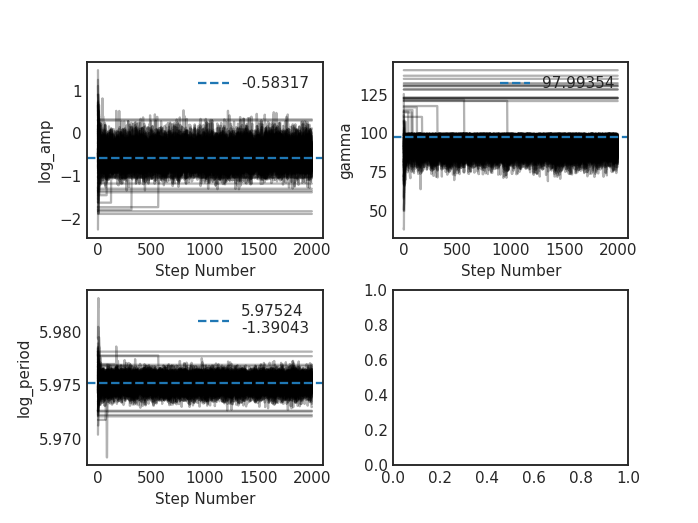

[ 0.6303222  95.10599193 -1.39079551]
Data points: 100
Mean acceptance fraction: 0.479


In [89]:
plot_steps(sampler, dims = ['log_amp', 'gamma', 'log_period'], p0=p0, data_pts=len(fsample))

In [ ]:
cgp.plot_hist(sampler)

In [ ]:
fig = corner.corner(sampler.flatchain)

## Evil plotting happening down here.

In [91]:
from plotting import plot_lightcurve, plot_folded_lightcurve


/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/dynesty/bounding.py:73: UserWarning: Robust OAS shrunk covariance estimator from `sklearn` is not available. Defaulting to MLE estimator from `numpy`.
  warnings.warn("Robust OAS shrunk covariance estimator from `sklearn` is "


ModuleNotFoundError: No module named 'gatspy'

<IPython.core.display.Javascript object>


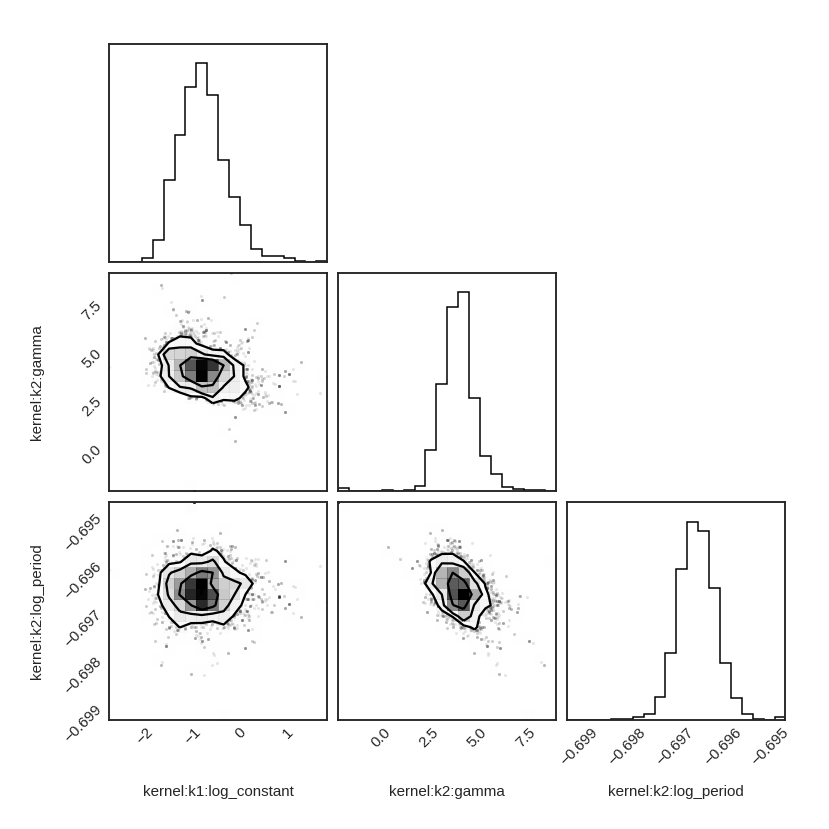

<IPython.core.display.Javascript object>


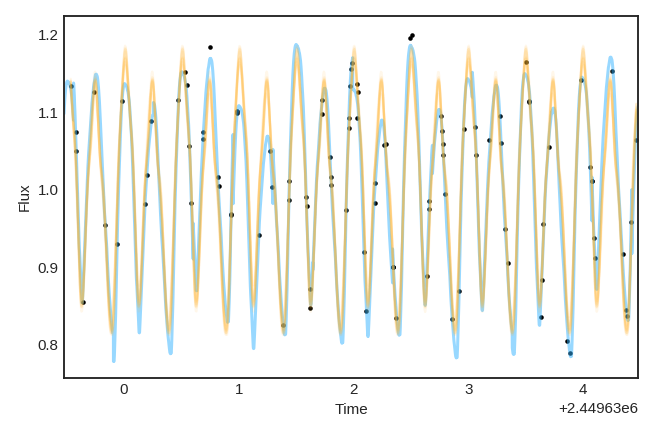

<IPython.core.display.Javascript object>


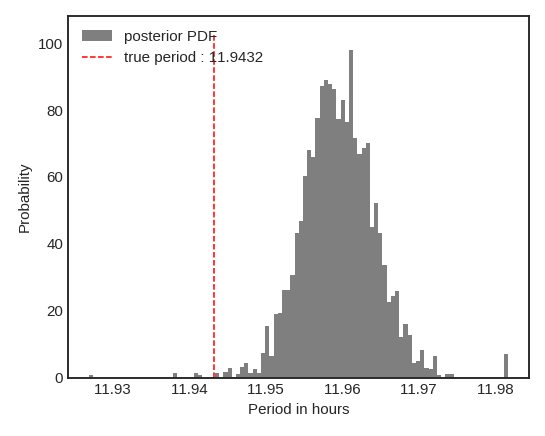

<IPython.core.display.Javascript object>


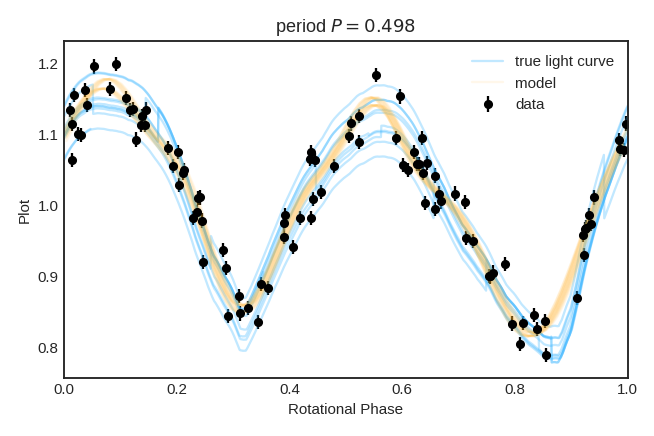

In [43]:
#true_period = 3.603957 # 3200 Phaeton
#true_period = 5.58410 # 1291 Phryge
#true_period = 10.443 # 221 Eos
true_period = 11.9432 # 1388 Aphrodite

plot_mcmc_sampling_results(tsample, fsample, flux_err, gp, sampler, namestr='lsp_3', true_lightcurve = [time, flux], true_period=true_period)

In [16]:
def plot_mcmc_sampling_results(time, flux, flux_err, gp, sampler,
                          t_pred=None, true_lightcurve=None,
                          true_period=None, namestr="test", 
                          nmodels=10, npred=1000):
    
    
    # resample from weights
    new_samples = sampler.flatchain
    
    # make a corner plot
    corner.corner(new_samples, labels=gp.get_parameter_names())

    # save to file
    plt.savefig(namestr + "_corner.pdf", format="pdf")

    # plot some light curves with example models

    # first, get the total number of available samples
    nsamples = new_samples.shape[0]

    # get some random samples from the 

    idx = np.random.choice(np.arange(0, nsamples, 1, dtype=int), size=nmodels)

    # if the array for the predictions isn't given, make one
    if t_pred is None:
        t_pred = np.linspace(time[0], time[-1], npred)

    # empty array for output
    m_all = np.zeros((nmodels, t_pred.shape[0]))

    # loop through the indices of samples, for each sample from the GP
    # conditional on the data points
    for i,j in enumerate(idx):
        p = new_samples[j]
        pnew = [p[0], p[1], p[2]]#, p[3]]

        gp.set_parameter_vector(pnew)
        mean_model = gp.sample_conditional(fsample, t_pred)
        m_all[i] = mean_model

    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    plot_lightcurve(tsample, fsample, true_lightcurve=true_lightcurve, 
                        models=(t_pred, m_all), ax=ax)

    plt.tight_layout()
    plt.savefig(namestr + "_lc.pdf", format="pdf")

    # plot histogram of periods
    fig, ax = plt.subplots(1, 1, figsize=(5,4))
    ax.hist(np.exp(new_samples[:,-1])*24, bins=100, normed=True, 
                label="posterior PDF", color="black", alpha=0.5)

    if true_period is not None:
        ylim = ax.get_ylim()
        ax.vlines(true_period, 0, ylim[-1], lw=1, color="red", linestyle="dashed", label="true period : " + str(true_period))

    ax.set_xlabel("Period in hours")
    ax.set_ylabel("Probability")
    ax.legend()

    plt.tight_layout()
    plt.savefig(namestr + "_period_pdf.pdf", format="pdf")

    # plot folded light curve

    fig, ax = plt.subplots(1, 1, figsize=(6,4))


    if true_period:
        ax = plot_folded_lightcurve(tsample, fsample, true_period/24, flux_err=0.01, 
                          models=[t_pred, m_all[:2]], 
                          true_lightcurve=true_lightcurve, ax=ax, use_radians=False)
    else:
        ax = plot_folded_lightcurve(tsample, fsample, best_period, flux_err=flux_err, 
                          models=[t_pred, m_all[:2]], 
                          true_lightcurve=true_lightcurve, ax=bx, use_radians=False)

    plt.tight_layout()
    plt.savefig(namestr + "_folded_lc.pdf", format="pdf")
